#### Load and Prepare Data

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import tkinter as tk
from PIL import Image, ImageGrab, ImageTk, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os


print(torch.__version__)

2.0.1


In [3]:
# Setup the data transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5, fill=(255, 255, 255)),
    transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

data_path = "images"
datasets = torchvision.datasets.ImageFolder(root = data_path, transform = transform)

data_loader = torch.utils.data.DataLoader(datasets, batch_size= 2, shuffle = True)

Label: Triangle


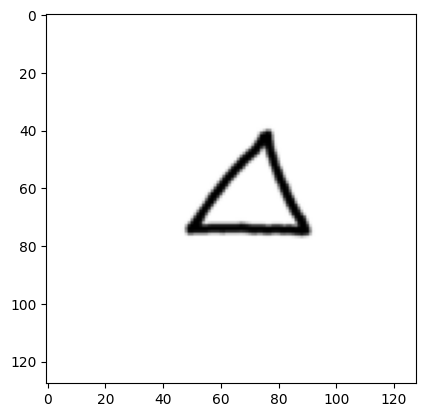

Label: Triangle


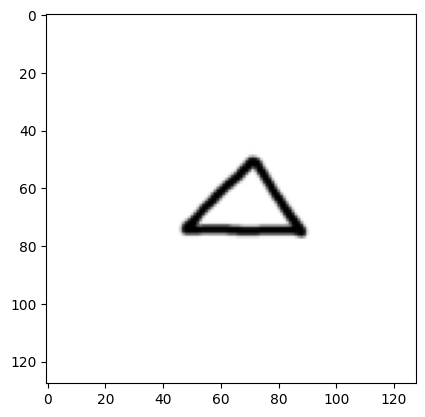

In [4]:
# Make sure images are correct
def imshow(img_tensor):
    # Convert from tensor to numpy array
    np_img = img_tensor.numpy()
    # Change from (C, H, W) to (H, W, C) for visualization
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Visualize images in the batch
for i in range(images.size(0)):
    print(f"Label: {datasets.classes[labels[i]]}")
    imshow(images[i])

In [ ]:
# Data Augmentation
img_num = 0

# Base directory for augmented images
augmented_base_dir = "augmented_images"

# Create a base directory for the augmented images if not exists
if not os.path.exists(augmented_base_dir):
    os.mkdir(augmented_base_dir)

for _ in range(500):
    for img, label in datasets:
        
        # Get the folder name from the label
        folder_name = [folder for folder, idx in datasets.class_to_idx.items() if idx == label][0]
        
        # Create a directory for each class inside augmented_images if it does not exist
        augmented_class_path = os.path.join("augmented_images", folder_name)
        if not os.path.exists(augmented_class_path):
            os.makedirs(augmented_class_path)
        
        # Save the augmented image
        torchvision.utils.save_image(img, os.path.join(augmented_class_path, 'img'+str(img_num)+'.png'))
        img_num += 1


In [6]:
# Update the working datasets
augmented_data_path = "augmented_images"
augmented_datasets = torchvision.datasets.ImageFolder(root = augmented_data_path, transform = transform)

augmented_data_loader = torch.utils.data.DataLoader(datasets, batch_size= 32, shuffle = True)

# Display class names and index labels for debug
print("Class names: ", augmented_datasets.classes)
print("Class index mapping:", augmented_datasets.class_to_idx)

Class names:  ['Square', 'Triangle']
Class index mapping: {'Square': 0, 'Triangle': 1}


Total Images: 3000
Training Images: 2400
Validation Images: 600


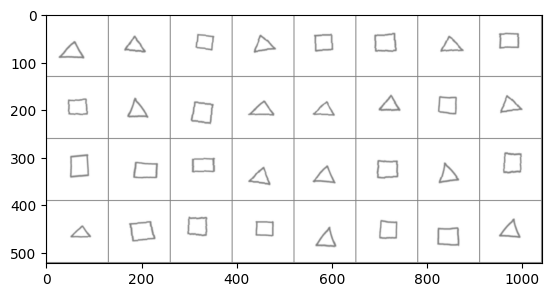

Labels: tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1])


In [7]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(augmented_datasets))
valid_size = len(augmented_datasets) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(augmented_datasets, [train_size, valid_size])

print(f"Total Images: {len(augmented_datasets)}")
print(f"Training Images: {len(train_dataset)}")
print(f"Validation Images: {len(valid_dataset)}")

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size= 32, shuffle = False)

# Function to unnormalize and plot image
def imshow(img):
    img = img / 2 + 0.5  # Assuming normalization was mean=0.5 and std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))
print("Labels:", labels)

#### Define the Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# Set up the neural net
class SimpleCNN(nn.Module):
    def __init__ (self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding = 1)
        
        # Adjusted for 32x32 feature map with 16 channels
        self.fc1 = nn.Linear(16*32*32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # first conv, ReLU, pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # second conv, ReLU, pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten the tensor
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
num_classes = len(augmented_datasets.classes)
model = SimpleCNN(num_classes)

#### Specify Loss Function and Optimizer

In [10]:
lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

#### Train the Model

In [12]:
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get class predictions
        loss = lossf(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        correct_train += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct_train.double() / len(train_loader.dataset)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = lossf(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            correct_val += torch.sum(preds == labels.data)

    val_loss = val_loss / len(valid_loader.dataset)
    val_accuracy = correct_val.double() / len(valid_loader.dataset)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print('-' * 60)

Epoch 1/10
Training Loss: 0.5711, Training Accuracy: 0.8413
Validation Loss: 0.3607, Validation Accuracy: 0.9317
------------------------------------------------------------
Epoch 2/10
Training Loss: 0.2224, Training Accuracy: 0.9550
Validation Loss: 0.1159, Validation Accuracy: 0.9800
------------------------------------------------------------
Epoch 3/10
Training Loss: 0.0899, Training Accuracy: 0.9783
Validation Loss: 0.0484, Validation Accuracy: 0.9900
------------------------------------------------------------
Epoch 4/10
Training Loss: 0.0497, Training Accuracy: 0.9871
Validation Loss: 0.0234, Validation Accuracy: 0.9967
------------------------------------------------------------
Epoch 5/10
Training Loss: 0.0436, Training Accuracy: 0.9904
Validation Loss: 0.0344, Validation Accuracy: 0.9900
------------------------------------------------------------
Epoch 6/10
Training Loss: 0.0333, Training Accuracy: 0.9904
Validation Loss: 0.0138, Validation Accuracy: 0.9983
-----------------

#### Evaluate the Model

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 99.83%
Test Accuracy: 99.42%


#### Live Prediction

In [ ]:
# Assuming the SimpleCNN class definition is already present
# model = torch.load('model/model1.pth')
# model.eval()

In [14]:
# Ensure the model is in evaluation mode
model.eval()

# Transform function
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to the input size your model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standard normalization values
])

In [15]:
class DrawingApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Prediction Board")

        self.canvas = tk.Canvas(root, bg="white", width=500, height=500)
        self.canvas.pack(pady=20)
        
        self.canvas.bind("<B1-Motion>", self.paint)
        self.canvas.bind("<ButtonRelease-1>", self.reset_last_coordinates)

        self.predict_button = tk.Button(root, text="Predict", command=self.predict)
        self.predict_button.pack(pady=20)

        self.clear_button = tk.Button(root, text="Clear", command=self.clear_screen)
        self.clear_button.pack(pady=20)

        self.result_label = tk.Label(root, text="", font=("Arial", 12))
        self.result_label.pack(pady=20)

        self.last_x, self.last_y = None, None

    def paint(self, event):
        x, y = event.x, event.y
        if self.last_x and self.last_y:
            self.canvas.create_line((self.last_x, self.last_y, x, y), width=10, fill='black', capstyle=tk.ROUND, smooth=tk.TRUE)
        self.last_x, self.last_y = x, y

    def reset_last_coordinates(self, event):  
        self.last_x, self.last_y = None, None

    def clear_screen(self):
        self.canvas.delete("all")
        self.result_label.config(text="")  # Clear the result label

    def predict(self):
        # Capture the canvas content and convert it to a PIL Image
        x = self.root.winfo_rootx() + self.canvas.winfo_x()
        y = self.root.winfo_rooty() + self.canvas.winfo_y()
        x1 = x + self.canvas.winfo_width()
        y1 = y + self.canvas.winfo_height()

        img = ImageGrab.grab(bbox=(x, y, x1, y1)).convert('RGB')
        
        # Transform the image and make a prediction
        img_tensor = transform(img).unsqueeze(0)
        
        with torch.no_grad():
            output = model(img_tensor)
            prediction = output.argmax(dim=1).item()
        
        predicted_class = augmented_datasets.classes[prediction]
        probability = F.softmax(output, dim=1)
        confidence = probability[0][prediction].item()
        
        # Display the prediction in the label widget
        self.result_label.config(text=f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}")


In [16]:
if __name__ == "__main__":
    root = tk.Tk()
    app = DrawingApp(root)
    root.mainloop()

: 